# RNN - Insurance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel('../raw_data/weekly_data_clean.xlsx', engine='openpyxl')

In [3]:
data = data.drop(columns=['Unnamed: 0', 'date_issue'])

In [4]:
data

,total_amount_claims
0,16683
1,201774
2,263661
3,799703
4,900305
...,...
127,1949930
128,1725225
129,2232202
130,2666662


In [5]:
print("min: ",data['total_amount_claims'].min())
print("max: ",data['total_amount_claims'].max())

min:  16683
max:  2666662


In [6]:
data.shape

(132, 1)

In [7]:
min_ = data['total_amount_claims'].min()
max_ = data['total_amount_claims'].max()

data['total_amount_claims'] = [((x - min_) / (max_ - min_)) for x in data['total_amount_claims']]

In [8]:
data

,total_amount_claims
0,0.000000
1,0.069846
2,0.093200
3,0.295482
4,0.333445
...,...
127,0.729533
128,0.644738
129,0.836052
130,1.000000


### Split data

In [11]:
len_ = int(0.8*data.shape[0])

data_train = data[:len_]
data_test = data[len_:]

In [12]:
print(data_train.shape)
print(data_test.shape)

(105, 1)
(27, 1)


### Sequences

In [13]:
def subsample_sequence(data, length):
    
    last_possible = data.shape[0] - length
    
    random_start = np.random.randint(0, last_possible)
    data_sample = data[random_start: random_start+length]
    
    return data_sample

In [14]:
data_subsample = subsample_sequence(data, 10)
data_subsample

,total_amount_claims
82,0.277267
83,0.144128
84,0.099856
85,0.179453
86,0.161471
87,0.154914
88,0.214978
89,0.169755
90,0.245852
91,0.264198


In [15]:
def fillna(X, data_mean):
    # Replace with NaN of the other hours. 
    na = X.mean()
    
    # If the other hours are also nans, then replace with mean value of the dataframe
    na.fillna(data_mean)
    return na

def split_subsample_sequence(data, length, data_mean=None):
    # Little trick to improve the time
    if data_mean is None:
        data_mean = data.mean()
              
    data_subsample = subsample_sequence(data, length)
    y_sample = data_subsample.iloc[data_subsample.shape[0]-1]['total_amount_claims']
    
    if y_sample != y_sample: # A value is not equal to itself only for NaN. So it will be True if y_sample is nan
        X_sample, y_sample = split_subsample_sequence(data, length, data_mean)
        return np.array(X_sample), np.array(y_sample)
    
    X_sample = data_subsample[0:data_subsample.shape[0]-1]
    X_sample = X_sample.fillna(fillna(X_sample, data_mean))
    X_sample = X_sample.values
    
    return np.array(X_sample), np.array(y_sample)

In [16]:
def get_X_y(data, number_of_sequences, length):
    X, y = [], []

    for i in range(number_of_sequences):
        xi, yi = split_subsample_sequence(data, length)
        X.append(xi)
        y.append(yi)
        
    X = np.array(X)
    y = np.array(y)
        
    return X, y

In [22]:
X_train, y_train = get_X_y(data_train, 80, 10)
X_test, y_test = get_X_y(data_test, 20, 10)

In [ ]:
# !pip install tensorflow

In [23]:
print(f'X train size:{X_train.shape}')
print(f'X test size:{X_test.shape}')
print(f'y train size:{y_train.shape}')
print(f'y test size:{y_test.shape}')

X train size:(80, 9, 1)
X test size:(20, 9, 1)
y train size:(80,)
y test size:(20,)


In [ ]:
X_train

In [25]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

model.add(layers.LSTM(20, activation='tanh'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

In [26]:
model.compile(loss='mse', 
              optimizer='rmsprop', 
              metrics=['mse', 'mae', 'mape'])

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train,
            validation_split=0.2,
            epochs=100, 
            batch_size=16,
            callbacks=[es])

Epoch 1/100
4/4 [==============================] - 3s 414ms/step - loss: 0.0835 - mae: 0.2622 - mape: 116.9708 - val_loss: 0.0576 - val_mae: 0.2070 - val_mape: 91.8599
Epoch 2/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0646 - mae: 0.2248 - mape: 90.8873 - val_loss: 0.0515 - val_mae: 0.1924 - val_mape: 83.3466
Epoch 3/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0662 - mae: 0.2163 - mape: 82.9249 - val_loss: 0.0466 - val_mae: 0.1794 - val_mape: 75.6830
Epoch 4/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0560 - mae: 0.1959 - mape: 75.8986 - val_loss: 0.0419 - val_mae: 0.1659 - val_mape: 67.7413
Epoch 5/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0464 - mae: 0.1734 - mape: 67.0804 - val_loss: 0.0371 - val_mae: 0.1512 - val_mape: 59.1158
Epoch 6/100
4/4 [==============================] - 0s 33ms/step - loss: 0.0449 - mae: 0.1656 - mape: 60.3912 - val_loss: 0.0324 - val_mae: 0.1359 - val_mape: 50.4202
Ep

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (16, 20)                  1760      
_________________________________________________________________
dense (Dense)                (16, 5)                   105       
_________________________________________________________________
dense_1 (Dense)              (16, 1)                   6         
Total params: 1,871
Trainable params: 1,871
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_eval = model.evaluate(X_test, y_test, verbose=0)
# print(f'Model Mean Absolute Error {model_eval[1]:.4f}')
# print(f'Model Mean Absolute Porcentual Error {model_eval[2]:.4f}')
model_eval

[0.020526807755231857, 0.10470175743103027, 16.476547241210938]

In [ ]:
# tf.keras.losses.MAPE(
#     y_true, y_pred
# )

#### Prediction

In [31]:
predict = model.predict(X_test)

In [32]:
predict

array([[0.43105718],
       [0.43946463],
       [0.5258971 ],
       [0.4882678 ],
       [0.4552067 ],
       [0.40886956],
       [0.49741635],
       [0.49741635],
       [0.5022563 ],
       [0.5022563 ],
       [0.4882678 ],
       [0.49741635],
       [0.49717262],
       [0.5258971 ],
       [0.50700593],
       [0.6041861 ],
       [0.43105718],
       [0.4552067 ],
       [0.4394646 ],
       [0.50700593]], dtype=float32)

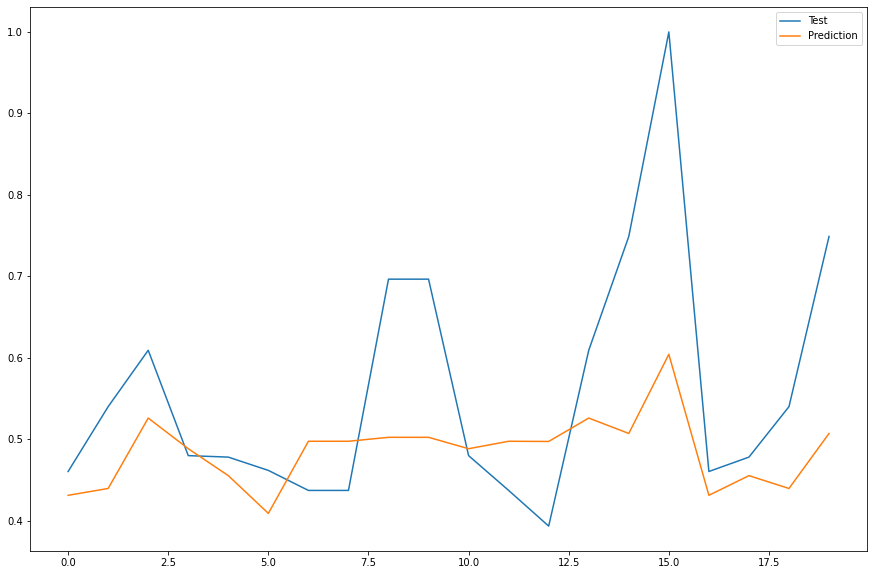

In [33]:
plt.figure(figsize=(15,10))
plt.plot(y_test,label = 'Test')
plt.plot(predict, label = 'Prediction')
plt.legend(loc='best')
plt.show()